#Per ottenere i vettori del vocabolario
https://github.com/vijayaiitk/NLP-text-classification-model/issues/1

Prendi le parole più simili
https://aneesha.medium.com/using-tsne-to-plot-a-subset-of-similar-words-from-word2vec-bb8eeaea6229
https://stackoverflow.com/questions/37818426/get-most-similar-words-given-the-vector-of-the-word-not-the-word-itself
https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.most_similar.html

In [1]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [115]:
import pandas as pd
import nltk
import numpy as np
import string

from mi_helper import *
from sklearn.pipeline import Pipeline

from numpy import array 

In [116]:
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases

In [117]:
from nltk import sent_tokenize
from nltk import pos_tag

In [118]:
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

In [119]:
dataset = pd.read_csv("amazon_alexa.tsv", sep = "\t")
dataset.tail()

,rating,date,variation,verified_reviews,feedback
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1
3149,4,29-Jul-18,Black Dot,Good,1


In [625]:
dataset.drop(dataset[dataset.rating == 3].index, inplace=True) #droppa recensioni con 3-4 stelle
dataset.drop(dataset[dataset.rating == 4].index, inplace=True)

In [623]:
# CREAZIONE DI UN SAMPLE DATASET BILANCIATO
# prende le prime n recensioni positive di lunghezza maggiore, dove n è il numero di recensioni negative
def create_balanced_dataset(dataset):
    """Bilancia il dataset uniformando il numero di recensioni negative e positive. Prende in input il dataset"""
    reviews_1 = list(dataset[dataset["feedback"] == 1]["verified_reviews"])
    reviews_0 = list(dataset[dataset["feedback"] == 0]["verified_reviews"])
    reviews_1.sort(key=len, reverse = True)
    sample_1 = reviews_1[:len(reviews_0)]
    verified_reviews_sample = []
    feedback_sample = []
    verified_reviews_sample.extend(sample_1)
    verified_reviews_sample.extend(reviews_0)
    feedback_sample.extend([1 for i in range(len(sample_1))])
    feedback_sample.extend([0 for i in range(len(reviews_0))])
    dataset = pd.DataFrame({"verified_reviews":verified_reviews_sample, "feedback": feedback_sample})
    print(dataset["feedback"].value_counts())
    return dataset


dataset = create_balanced_dataset(dataset)

1    257
0    257
Name: feedback, dtype: int64


In [120]:
corpus =''
for review in dataset["verified_reviews"]:
    corpus+=" " + review
sentences = sent_tokenize(corpus)
sentences

[' Love my Echo!',
 'Loved it!',
 'Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you.',
 'I like being able to turn lights on and off while away from home.',
 'I have had a lot of fun with this thing.',
 'My 4 yr old learns about dinosaurs, i control the lights and play games like categories.',
 'Has nice sound when playing music as well.',
 'Music I received the echo as a gift.',
 'I needed another Bluetooth or something to play music easily accessible, and found this smart speaker.',
 'Can’t wait to see what else it can do.',
 'Without having a cellphone, I cannot use many of her features.',
 'I have an iPad but do not see that of any use.',
 'It IS a great alarm.',
 'If u r almost deaf, you can hear her alarm in the bedroom from out in the living room, so that is reason enough to keep her.It is fun to ask random questions to hear her response.',
 'She does not seem to be very smartbon politics yet.',
 "I t

In [121]:
def get_wordnet_pos(treebank_tag):
    """
    return WORDNET POS compliance to WORDENT lemmatization (a,n,r,v) 
    """
    if treebank_tag.startswith('J'):
        return "a"
    elif treebank_tag.startswith('V'):
        return "v"
    elif treebank_tag.startswith('N'):
        return "n"
    elif treebank_tag.startswith('R'):
        return "r"
    else:
        return "n"
        
custom_stopwords = ["echo", "alexa", "dot", "amazon", "prime", "2nd", "generation", "1st", "3rd", "4th", "5th", "google", "netflix", "youtube", "philip", "tp-link"]
pos_list = ["JJ", "JJR", "JJS", "RB", "RBR", "RBS", "VB", "VBD", "VBG", "VBN", "VBP", "VBZ"]

def tokenize_list_of_text(list_of_text, custom_stopwords = [], pos_filter = False, pos_list = []):
    """Tokenizza tutte le recensioni, pulisce da stopwords, elimina token <= 2 caratteri e lemmatizza. Ritorna la colonna delle recensioni."""

    tokenizer = nltk.tokenize.TweetTokenizer()
    lemmatizer = nltk.WordNetLemmatizer()
    tokenized_reviews = []
    sent_tokenized_reviews = []
    for review in list_of_text: #pulisce le recensioni
        clean_text = ""
        tokens = tokenizer.tokenize(review)
        tokens = [w.lower() for w in tokens]
        tokens_pos = pos_tag(tokens)
        lemmatized_tokens = [(lemmatizer.lemmatize(w, get_wordnet_pos(pos)), pos) for w, pos in tokens_pos]
        if pos_filter:
            clean_tokens = [(w, pos) for w, pos in lemmatized_tokens if w not in string.punctuation and len(w)>2 and w not in stopwords.words("english") and w not in custom_stopwords and pos in pos_list]
        else:
            clean_tokens = [(w, pos) for w, pos in lemmatized_tokens if w not in string.punctuation and len(w)>2 and w not in stopwords.words("english") and w not in custom_stopwords]
        sent_tokenized_reviews.append([w for w, pos in clean_tokens])
        for w, pos in clean_tokens:
            clean_text += " " + w
        tokenized_reviews.append(clean_text)
    
    n_tokens = []
    for sent in sent_tokenized_reviews:
        for w in sent:
            n_tokens.append(w)
    print("total number of tokens extracted are:", len(set(n_tokens)))
    return tokenized_reviews,  sent_tokenized_reviews # ritorna una tupla!

In [122]:
new_text, new_sent_tok = tokenize_list_of_text(sentences, custom_stopwords, False, pos_list)
# contengono una lista di tutte le frasi pre processate, nella prima variabile in stringa, nella seconda in tokens 

total number of tokens extracted are: 3271


In [15]:
bigrams = Phrases(new_sent_tok)
bigrams[new_sent_tok]

In [9]:
new_sent_tok

[['love'],
 ['love'],
 ['sometimes',
  'play',
  'game',
  'answer',
  'question',
  'correctly',
  'say',
  'get',
  'wrong',
  'answer'],
 ['like', 'able', 'turn', 'light', 'away', 'home'],
 ['lot', 'fun', 'thing'],
 ['old',
  'learns',
  'dinosaur',
  'control',
  'light',
  'play',
  'game',
  'like',
  'category'],
 ['nice', 'sound', 'play', 'music', 'well'],
 ['music', 'receive', 'gift'],
 ['need',
  'another',
  'bluetooth',
  'something',
  'play',
  'music',
  'easily',
  'accessible',
  'find',
  'smart',
  'speaker'],
 ['wait', 'see', 'else'],
 ['without', 'cellphone', 'cannot', 'use', 'many', 'feature'],
 ['ipad', 'see', 'use'],
 ['great', 'alarm'],
 ['almost',
  'deaf',
  'hear',
  'alarm',
  'bedroom',
  'living',
  'room',
  'reason',
  'enough',
  'keep',
  'her.it',
  'fun',
  'ask',
  'random',
  'question',
  'hear',
  'response'],
 ['seem', 'smartbon', 'politics', 'yet'],
 ['think', 'one', "i've", 'purchase'],
 ["i'm", 'work', 'get', 'one', 'every', 'room', 'house']

In [123]:
#window = numero di token, min_num = frequenza minima dei token, sg = traing algorithm - skip-gram, negative = negative example
#aggiorna soltato un numero k di pesi nella rete per le parole più informative 
w2v_model = Word2Vec(bigrams[new_sent_tok], vector_size=100, window=2, min_count = 5, sg=1, epochs=20, negative=10)

# 
# PROVARE CON BIGRAMMI gensim.phrases() fa calcolo delle collocazioni con pmi

In [124]:
len(w2v_model.wv.vectors)

1031

In [125]:
w2v_model.wv.most_similar(['love'], topn = 20) #Nearest neighboor --> high cosine similarity

[('absolutely_love', 0.8241608142852783),
 ('spot', 0.8194350600242615),
 ('look_brand', 0.8164448738098145),
 ('fantastic', 0.8141229152679443),
 ('pleased', 0.8134680390357971),
 ('guy', 0.802373468875885),
 ('fire_stick', 0.795146107673645),
 ('offer', 0.7912009954452515),
 ('gadget', 0.7897416949272156),
 ('around_house', 0.7892731428146362),
 ('satisfied', 0.7889767289161682),
 ('experience', 0.7863981127738953),
 ('firestick', 0.7863239645957947),
 ('outstanding', 0.7860017418861389),
 ('tap', 0.784603476524353),
 ('cool', 0.7810758352279663),
 ('awesome', 0.780371367931366),
 ('delivery', 0.7784775495529175),
 ('toy', 0.7782286405563354),
 ('condition', 0.7717783451080322)]

In [128]:
w2v_model.wv.most_similar(['love'], topn = len(w2v_model.wv.vectors))[-100:] # less similar words

[('error', 0.4532584846019745),
 ('reminder', 0.45082253217697144),
 ('play_music', 0.4497593939304352),
 ('issue', 0.44911983609199524),
 ('living_room', 0.44870418310165405),
 ('power', 0.4486565589904785),
 ('place', 0.448241263628006),
 ('cannot', 0.4480385184288025),
 ('call', 0.44651779532432556),
 ('else', 0.44493433833122253),
 ('middle_night', 0.44425252079963684),
 ('etc', 0.44422274827957153),
 ('first', 0.4432944059371948),
 ('room', 0.44310644268989563),
 ('still', 0.4420316517353058),
 ('top', 0.44075945019721985),
 ('plus', 0.4405193030834198),
 ('speaker', 0.43753042817115784),
 ('wish', 0.43610721826553345),
 ('alarm', 0.43554508686065674),
 ('minute', 0.43353331089019775),
 ('request', 0.43288615345954895),
 ('pay', 0.43089333176612854),
 ('even_though', 0.4266314208507538),
 ('able', 0.42574384808540344),
 ('hue', 0.4254119396209717),
 ('pandora', 0.4227744936943054),
 ('blue_tooth', 0.4217190444469452),
 ('type', 0.4174189269542694),
 ('list', 0.41644442081451416),


In [93]:
w2v_model.wv.vectors[0] # contiene i vettori

array([-3.06412186e-02,  7.58131593e-02, -6.29538950e-03,  9.90935881e-03,
        4.28923080e-03, -3.06588978e-01,  2.89907325e-02,  4.07586098e-01,
       -2.03537583e-01, -1.62312657e-01, -2.20265742e-02, -1.94615364e-01,
       -5.54147847e-02,  5.91228195e-02,  3.48441787e-02, -8.81914347e-02,
        7.23898634e-02, -1.58888429e-01,  2.96081672e-03, -5.05850673e-01,
        1.05084874e-01,  3.19325104e-02,  1.50863379e-01, -1.26161113e-01,
       -1.90066800e-01,  5.87272272e-02, -1.12518162e-01, -4.00866568e-02,
       -5.48058003e-02,  1.22577280e-01,  2.73307621e-01,  1.69158040e-03,
        9.66221392e-02, -2.28181303e-01, -1.40773728e-01,  1.83325961e-01,
        9.33317468e-02, -4.70221899e-02, -1.73243079e-02, -2.95014143e-01,
        1.05751008e-01, -2.16268614e-01, -8.17192942e-02,  3.99846621e-02,
        2.21535653e-01, -6.46384582e-02, -8.63503739e-02, -1.19993478e-01,
        4.00678515e-02,  1.11261219e-01,  3.73165676e-04, -9.51859541e-03,
        6.88891262e-02, -

The structure is called “KeyedVectors” and is essentially a mapping between keys and vectors. Each vector is identified by its lookup key, most often a short string token, so this is usually a mapping between {str => 1D numpy array}
https://radimrehurek.com/gensim/models/keyedvectors.html

Other useful internals in Gensim 4.0+ include model.wv.index_to_key, a plain list of the key (word) in each index position, and model.wv.key_to_index, a plain dict mapping keys (words) to their index positions.

In [129]:
w2v_model.wv.key_to_index

{'love': 0,
 'great': 1,
 'use': 2,
 'like': 3,
 'work': 4,
 'get': 5,
 'good': 6,
 'one': 7,
 'device': 8,
 'sound': 9,
 'music': 10,
 'buy': 11,
 'product': 12,
 'thing': 13,
 'speaker': 14,
 'time': 15,
 '...': 16,
 'show': 17,
 'would': 18,
 'set': 19,
 'easy': 20,
 'day': 21,
 'much': 22,
 'really': 23,
 'new': 24,
 'need': 25,
 'also': 26,
 'home': 27,
 'purchase': 28,
 'play': 29,
 'want': 30,
 'make': 31,
 'ask': 32,
 'well': 33,
 'far': 34,
 'play_music': 35,
 'think': 36,
 'fun': 37,
 'connect': 38,
 'say': 39,
 'plus': 40,
 'easy_set': 41,
 'try': 42,
 'even': 43,
 "i'm": 44,
 'still': 45,
 'smart': 46,
 'everything': 47,
 'know': 48,
 'screen': 49,
 'little': 50,
 'tell': 51,
 'able': 52,
 'room': 53,
 'spot': 54,
 'feature': 55,
 'light': 56,
 'nice': 57,
 'learn': 58,
 'sound_quality': 59,
 'alarm': 60,
 'add': 61,
 'find': 62,
 'see': 63,
 'price': 64,
 'could': 65,
 'come': 66,
 'turn': 67,
 'house': 68,
 'way': 69,
 'another': 70,
 'without': 71,
 'bedroom': 72,
 'hear

In [130]:
w2v = dict(zip(w2v_model.wv.index_to_key, w2v_model.wv.vectors))
w2v

{'love': array([ 0.19116421,  0.09309368,  0.17430761,  0.03069269, -0.14523984,
        -0.24434716,  0.35471764,  0.50788105, -0.28694764, -0.37641022,
         0.02612213, -0.3551509 ,  0.16991746,  0.12938151, -0.03507606,
        -0.06050465,  0.05121879,  0.28181437, -0.3391179 , -0.78022194,
         0.14857918,  0.05905845,  0.2709593 ,  0.01495438, -0.02355741,
         0.03995674,  0.16013587,  0.08123016, -0.36731315,  0.18118861,
         0.00902133,  0.03302604,  0.21613708, -0.5224878 ,  0.00097278,
         0.34722295,  0.27407333, -0.14605755, -0.01562116,  0.06170608,
         0.07018192, -0.02190189, -0.04305044, -0.03683662,  0.4867238 ,
        -0.06528337, -0.2599184 , -0.23257384,  0.3080869 ,  0.00814291,
         0.13012747, -0.2933422 , -0.00719579, -0.12715346, -0.20258309,
         0.15766537,  0.06299143, -0.0950477 , -0.23332912,  0.1117157 ,
         0.08892634, -0.07913545,  0.23370576,  0.11395368,  0.02853185,
         0.4289213 ,  0.28325066,  0.259002

In [131]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statistics 
#from plotnine import *
import plotly.express as px
import plotly.graph_objects as go

from sklearn.metrics import *
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics.pairwise import cosine_similarity

from kneed import KneeLocator

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import SilhouetteVisualizer


#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram

In [132]:
vectors=w2v_model.wv.vectors
len(vectors)

1031

In [133]:
words = w2v_model.wv.index_to_key
len(words)

1031

In [100]:
sse_list = []
silhouette_list = []
for k in range(2, 51):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300)
    kmeans.fit(vectors)
    sse_list.append( kmeans.inertia_)
    silhouette_list.append(silhouette_score(vectors,kmeans.labels_))

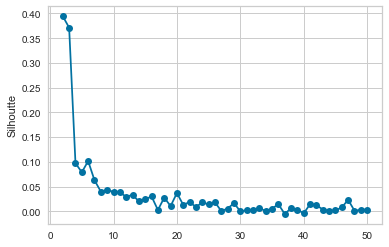

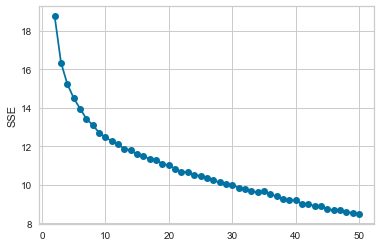

In [101]:
plt.plot(range(2, len(silhouette_list)+2), silhouette_list, marker='o')
plt.ylabel('Silhoutte')
plt.show()
plt.plot(range(2, len(sse_list)+2), sse_list, marker='o')
plt.ylabel('SSE')
plt.show()

In [134]:
kmeans = KMeans(n_clusters=2, n_init=10, max_iter=300)
kmeans.fit(vectors)

KMeans(n_clusters=2)

In [135]:
centers=kmeans.cluster_centers_ # centroidi
labels=kmeans.labels_ # clusters labels
np.unique(labels, return_counts=True) 

(array([0, 1]), array([379, 652], dtype=int64))

In [104]:
len(centers[0]) # lunghezza del vettore di un centroide

100

In [136]:
for i in centers:
    print(w2v_model.wv.most_similar(i, topn=20))
    print("####################################################")

[('sing', 0.9900145530700684), ('silly', 0.9878336191177368), ('whether', 0.9876476526260376), ('appointment', 0.9867229461669922), ('asleep', 0.9861232042312622), ('general', 0.9856958389282227), ('fire', 0.9838701486587524), ('mine', 0.9828673005104065), ('downside', 0.9814449548721313), ('reach', 0.9809733033180237), ('please', 0.9804356098175049), ('conversation', 0.9802195429801941), ('download_app', 0.9790603518486023), ('everyday', 0.9787594676017761), ('across_room', 0.978627622127533), ('date', 0.9785223603248596), ('personally', 0.9785077571868896), ('school', 0.9779819250106812), ('fall', 0.9778380990028381), ('confuse', 0.9772546887397766)]
####################################################
[('lag', 0.991873562335968), ('prove', 0.9899576902389526), ('major', 0.9893546104431152), ('complete', 0.9893181920051575), ('advertised', 0.9887994527816772), ('knowledge', 0.988542377948761), ('nearly', 0.9884560108184814), ('cute', 0.9874695539474487), ('previous', 0.98736321926116

In [137]:
df = pd.DataFrame()

In [138]:
print(len(w2v["love"]))
print(len(centers[0])) # to check if the vectors have the same length

100
100


In [139]:
from numpy import dot
from numpy.linalg import norm

words = []
labels = []
cos = []
for w, label in zip(w2v, kmeans.labels_):
    words.append(w)
    labels.append(label)
    # this calculates the similarity bewtween centroids and all the words in their clusters
    cos_sim = dot(w2v[w], centers[label])/(norm(w2v[w])*norm(centers[label])) # cosine similarity formula (dot(a, b)/norm(a)*norm(b))
    cos.append(cos_sim)
    
df["word"] = words
df["labels"] = labels
df["cos"] = cos

print(df[df["labels"] == 0].sort_values(by = "cos", ascending = False).to_markdown()) # shows the most similar words to that cluster

|      | word               |   labels |      cos |
|-----:|:-------------------|---------:|---------:|
| 1028 | sing               |        0 | 0.990014 |
| 1009 | silly              |        0 | 0.987834 |
| 1012 | whether            |        0 | 0.987648 |
|  860 | appointment        |        0 | 0.986723 |
|  985 | asleep             |        0 | 0.986123 |
| 1016 | general            |        0 | 0.985696 |
|  653 | fire               |        0 | 0.98387  |
|  776 | mine               |        0 | 0.982867 |
| 1021 | downside           |        0 | 0.981445 |
|  725 | reach              |        0 | 0.980973 |
|  535 | please             |        0 | 0.980436 |
|  726 | conversation       |        0 | 0.98022  |
|  895 | download_app       |        0 | 0.97906  |
|  852 | everyday           |        0 | 0.978759 |
|  883 | across_room        |        0 | 0.978628 |
|  748 | date               |        0 | 0.978522 |
|  897 | personally         |        0 | 0.978508 |
|  890 | sch

In [140]:
from sklearn.manifold import TSNE

In [141]:
tsne = TSNE(3, learning_rate="auto", metric="cosine")
tokens_list = []
for vec in w2v_model.wv.vectors:
    tokens_list.append(vec)

In [142]:
new_val = tsne.fit_transform(np.array(tokens_list))

c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



In [143]:
df["x"] = [x[0] for x in new_val]
df["y"] = [x[1] for x in new_val]
df["z"] = [x[2] for x in new_val]

In [144]:
print(df[df["labels"] == 0].sort_values(by = "cos", ascending = False).to_markdown())

|      | word               |   labels |      cos |           x |          y |          z |
|-----:|:-------------------|---------:|---------:|------------:|-----------:|-----------:|
| 1028 | sing               |        0 | 0.990014 | -2.28726    |  -8.34478  |  1.41703   |
| 1009 | silly              |        0 | 0.987834 | -1.56667    |  -8.31983  |  1.96479   |
| 1012 | whether            |        0 | 0.987648 | -0.850157   |  -6.11154  |  2.6454    |
|  860 | appointment        |        0 | 0.986723 | -0.720883   |  -7.63881  |  2.66531   |
|  985 | asleep             |        0 | 0.986123 | -0.262956   |  -6.7126   |  2.49476   |
| 1016 | general            |        0 | 0.985696 | -1.77403    |  -8.37722  |  0.977224  |
|  653 | fire               |        0 | 0.98387  | -2.8437     |  -8.23392  |  1.52345   |
|  776 | mine               |        0 | 0.982867 | -0.764578   |  -4.15313  |  1.71783   |
| 1021 | downside           |        0 | 0.981445 | -1.36564    |  -3.97386  |  

In [145]:
import seaborn as sns

<AxesSubplot:xlabel='x', ylabel='y'>

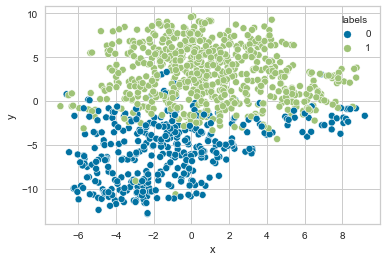

In [146]:
sns.scatterplot(data = df, x = "x", y = "y", hue = "labels")

In [147]:
import plotly_express as px

In [148]:
px.scatter_3d(data_frame = df, x = "x", y = "y", z = "z", color = [str(x) for x in df["labels"]], hover_name = "word")

In [149]:
# hierarchical clustering based on cosine distance

from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

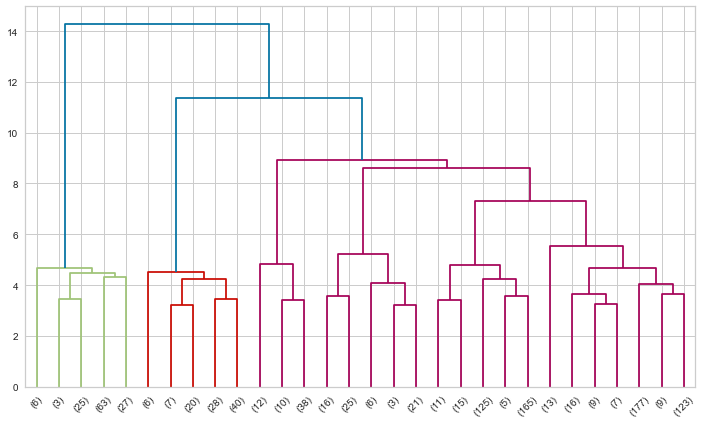

In [150]:
model = AgglomerativeClustering(n_clusters=None, distance_threshold=0, affinity = "euclidean", linkage = "ward", compute_full_tree = True)
model = model.fit(vectors)
plt.figure(figsize = (12, 7))
plot_dendrogram(model, truncate_mode = "lastp")

In [151]:
hier = AgglomerativeClustering(n_clusters = 2, affinity = "euclidean", linkage = "ward")
hier.fit(vectors)

AgglomerativeClustering()

In [57]:
hier_df = pd.DataFrame()
hier_df["word"] = list(w2v.keys())
hier_df["labels"] = hier.labels_
# hier_df["vec"] = vectors

hier_df["x"] = df["x"]
hier_df["y"] = df["y"]
hier_df["z"] = df["z"]
print(hier_df[hier_df["labels"] == 0].to_markdown())

|      | word          |   labels |         x |           y |           z |
|-----:|:--------------|---------:|----------:|------------:|------------:|
|    4 | music         |        0 | -15.25    |  5.54094    |  -4.76141   |
|   13 | play          |        0 | -12.9137  |  5.65736    |  -3.05873   |
|   32 | ask           |        0 |  -7.79902 |  1.35956    | -11.8364    |
|   33 | need          |        0 |   5.85177 |  5.72402    |   9.99083   |
|   44 | alarm         |        0 | -11.7203  | 10.3305     |   0.463431  |
|   47 | listen        |        0 | -12.3399  |  4.29937    |  -2.78196   |
|   53 | screen        |        0 | -11.0645  |  6.72285    |  -0.749675  |
|   54 | tell          |        0 | -11.1874  |  0.342226   |  -9.83125   |
|   60 | able          |        0 |  -9.85073 |  1.03217    |   2.44664   |
|   61 | weather       |        0 | -14.4379  | -2.04211    |  -6.82301   |
|   66 | clock         |        0 |  -9.76037 | 11.517      |   2.07107   |
|   84 | que

In [58]:
px.scatter_3d(data_frame = hier_df, x = "x", y = "y", z = "z", color = [str(x) for x in hier_df["labels"]], hover_name = "word")

In [167]:
df_polarity = pd.DataFrame()

words = []
positive_centroid = "love"
negative_centroid = "error"
positive = []
negative = []

for w in w2v:
    words.append(w)
    pos = dot(w2v[w], w2v[positive_centroid])/(norm(w2v[w])*norm(w2v[positive_centroid]))
    # neg = dot(w2v[w], w2v[negative_centroid])/(norm(w2v[w])*norm(w2v[negative_centroid]))
    neg = 1-pos
    positive.append(pos)
    negative.append(neg)

df_polarity["word"] = words
df_polarity["pos_score"] = positive
df_polarity["neg_score"] = negative

df_polarity.sort_values(by = "pos_score", ascending = False).head(20)

,word,pos_score,neg_score
0,love,1.000000,0.000000
210,absolutely_love,0.824161,0.175839
54,spot,0.819435,0.180565
805,look_brand,0.816445,0.183555
379,fantastic,0.814123,0.185877
240,pleased,0.813468,0.186532
546,guy,0.802373,0.197627
123,fire_stick,0.795146,0.204854
362,offer,0.791201,0.208799
514,gadget,0.789742,0.210258


In [174]:
pippo = """I hate this little device from hell. I used to love it. I bought one for every room in my house, my office at work, and they were good. But now, despite Amazon's alleged spying, some genius at Amazon decided to allow this thing to wake you up all hours of the night with a loud obnoxious noise and a bright yellow light. It will say you have a notification. Oh good, it must be a really good reason for Amazon to notify me of something mid sleep at 2 am on a Tuesday you ponder so you wake up the rest of the house by saying Alexa play notifications. Here's the best part, this little Alien Intelligence Robot without feet from hell will say Please rate the pair of shorts your wife bought last week, we need your review. Well I sure do love reviews, but at 2 am after being woken up to leave one, sadly I don't give a flying poopsicle about the shorts and a bug 1 star rating is all the revenge I can muster. This has been going on for weeks now. And it's enough to drive you mad because, you will contemplate unplugging the dirty little money siphon and cutting your losses, but you'll give the demon one more chance and she will allow you to sleep for a length of time in which you will forgive her treachery but then Boom, like a theif in the night a Hurricane will be boiling out in the Atlantic and this little weather girl from hell will want to notify you of the eminent doom 3 days ahead when the storm will be in your state. You will think how nice it is for all of the warnings you have heard thus far in social media,, television, and every news outlet in existence to be repeated to you as you climb into bed, but it gets even better. As soon as you listen to this golden nugget of doomsday propaganda and ponder how it is that you will sleep now because 3 days may not be enough time to dig a deep enough hole to hide from impending doom, she lights up again, oh my maybe flying dragons are headed this way, I better play the new notification, when your wife wakes up and says stop she has been doing that all evening, they literally keep changing the time of the storm by maybe an hour this way or that. Well by all means, the information could save one of our spoiled lives and we wouldn't want anyone to not know at which precise moment the raindrops will occur, but I do miss life before the artificial noises and alerts, bright yellow lights and bad news desserts. You may say that this is a growing pain with Alexa and AI technology kinks in the programming. I say with the amount of money I have poured into this monopolistic conglomerate, I should at least expect a decent night's sleep in return. You may say in page 74 paragraph D of the updated and revised owner's pamphlet there is a way to turn this "Feature" off, I welcome that comment but feel the need to say that I am not looking to become even slightly better educated on the device, I simply bought it to use as a voice controlled radio, this extra bologna does not appeal to me and has made me regret this purchase and every other from the brown box hq who secretly reads my mind, except when it comes to allowing me sleep, although kudos for recommending the sleep sounds, but it rarely works. We just need to be mindful of the 6 hours that most people like to not be disturbed. I regret selling my Amazon stock at 2400 and I regret purchasing all of these Alexa devices, and don't get me started on teenagers and Alexa devices, the combo that don't mix. They always, always, always leave the device at top volume, so when you walk into the bathroom at dawn and whisper Alexa what time is it, you then need to set an appointment for a blown eardrum and apologize to everyone for waking them up while the teen sleeps soundly through it all. Congratulations Amazon, you have destroyed my sanity. Weird goal but excellent execution."""

In [175]:
clean = tokenize_list_of_text([pippo], custom_stopwords, False, pos_list)[1][0]
bigrams_clean = Phrases([clean])
print(clean)
score = 0
for w in bigrams_clean.vocab:
    if df_polarity[df_polarity["word"] == w]["pos_score"].empty:
        print(w, "not found")
        score+=0
    else:
        pos = df_polarity[df_polarity["word"] == w]["pos_score"].values[0]
        neg = df_polarity[df_polarity["word"] == w]["neg_score"].values[0]
        print(w, "pos", pos, "neg", neg)
        score += pos
        score -= neg

total number of tokens extracted are: 243
['hate', 'little', 'device', 'hell', 'use', 'love', 'buy', 'one', 'every', 'room', 'house', 'office', 'work', 'good', 'despite', "amazon's", 'allege', 'spying', 'genius', 'decide', 'allow', 'thing', 'wake', 'hour', 'night', 'loud', 'obnoxious', 'noise', 'bright', 'yellow', 'light', 'say', 'notification', 'good', 'must', 'really', 'good', 'reason', 'notify', 'something', 'mid', 'sleep', 'tuesday', 'ponder', 'wake', 'rest', 'house', 'say', 'play', 'notification', "here's", 'best', 'part', 'little', 'alien', 'intelligence', 'robot', 'without', 'foot', 'hell', 'say', 'please', 'rate', 'pair', 'short', 'wife', 'buy', 'last', 'week', 'need', 'review', 'well', 'sure', 'love', 'review', 'wake', 'leave', 'one', 'sadly', 'give', 'fly', 'poopsicle', 'short', 'bug', 'star', 'rating', 'revenge', 'muster', 'week', 'enough', 'drive', 'mad', 'contemplate', 'unplug', 'dirty', 'little', 'money', 'siphon', 'cut', 'loss', 'give', 'demon', 'one', 'chance', 'allow',

In [176]:
score

13.428877979516983